## Packages
---
In this section, we import all the packages that will be used in this experiment

In [ ]:
#Data Downloading
from urllib.request import urlopen
import os
import gzip

# Dataframe Packages
import dask.dataframe as dd

# Data Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt

# Training Data Preparation
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Traditional Machine Learning Packages
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Deep Learning Packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import callbacks

# Saving ML Model
import joblib

import warnings
warnings.filterwarnings("ignore")

## Data Downloading
---
In this section, we will be using urllib to request and download job event and task event table from google cloud storage

In [ ]:
print('Task Event Table')
print('Download Started')
#Task Usage Table
url1 = 'https://commondatastorage.googleapis.com/clusterdata-2011-2/task_events/part-'
url2 = '-of-00500.csv.gz'
for x in range(500):
    while True:
        try:
            url = url1+("%05d" % x)+url2
            fname = 'data/task_events/part-'+("%05d" % x)+'-of-00500.csv.gz'
            data = urlopen(url).read()
            with open(fname, 'wb') as f:
                f.write(data)
        except:
            continue
        break
print('Download Complete')

Task Event Table
Download Started
Download Complete


## Data Extraction
---
In this section, the data that is downloaded from the cloud will be extracted

In [ ]:
def gunzip(source_filepath, dest_filepath, block_size=65536):
    with gzip.open(source_filepath, 'rb') as s_file, \
            open(dest_filepath, 'wb') as d_file:
        while True:
            block = s_file.read(block_size)
            if not block:
                break
            else:
                d_file.write(block)

In [ ]:
path1 = 'data/task_events/part-'
path2 = '-of-00500.csv.gz'
path3 = '-of-00500.csv'
print('Extraction Started')
for x in range(500):
    spath = path1 + ('%05d' % x) + path2
    dpath = path1 + ('%05d' % x) + path3
    gunzip(spath, dpath)
    os.remove(spath)
print('Extraction Finished')

Extraction Started
Extraction Finished


## Data Preparation

### Data Extraction
---
In this section, we load the data into the memory. We use dask dataframe as the amount of data is large and cannot be save at the RAM

In [ ]:
task_event = dd.read_csv('data/task_events/*.csv', names=['Time','Missing Info','Job ID','Task Index','Machine ID','Event Type','User Name','Scheduling Class','Priority','CPU Request','Memory Request','Disk Space Request','Different Machine Restriction'],assume_missing=True)

In [ ]:
task_event.head()

,Time,Missing Info,Job ID,Task Index,Machine ID,Event Type,User Name,Scheduling Class,Priority,CPU Request,Memory Request,Disk Space Request,Different Machine Restriction
0,0.0,2.0,3418309.0,0.0,4.155527e+09,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3.0,9.0,NaN,NaN,NaN,NaN
1,0.0,2.0,3418309.0,1.0,3.291507e+08,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3.0,9.0,NaN,NaN,NaN,NaN
2,0.0,NaN,3418314.0,0.0,3.938719e+09,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3.0,9.0,0.125,0.07446,0.000424,0.0
3,0.0,NaN,3418314.0,1.0,3.516186e+08,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3.0,9.0,0.125,0.07446,0.000424,0.0
4,0.0,2.0,3418319.0,0.0,4.310529e+08,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3.0,9.0,NaN,NaN,NaN,NaN


### Data Selection
---
In this section, we will select the data that will be use as a sample dataset for model training later on.

In [ ]:
task_event = task_event[task_event.Time != 0]
task_event = task_event[task_event.Time < 604800600000]
task_event = task_event[task_event['Event Type'] > 1]
task_event = task_event[task_event['Event Type'] < 7]

### Data Transformation
---
In this section, we grouped all the event type into two group which are success and failure. We mark success job as 1 and job failure as 0

In [ ]:
task_event = task_event.replace({'Event Type':{2:0, 3:0, 4:1, 5:0, 6:0}})

Text(0.5, 1.0, 'Feature Correlating with Task Failure')

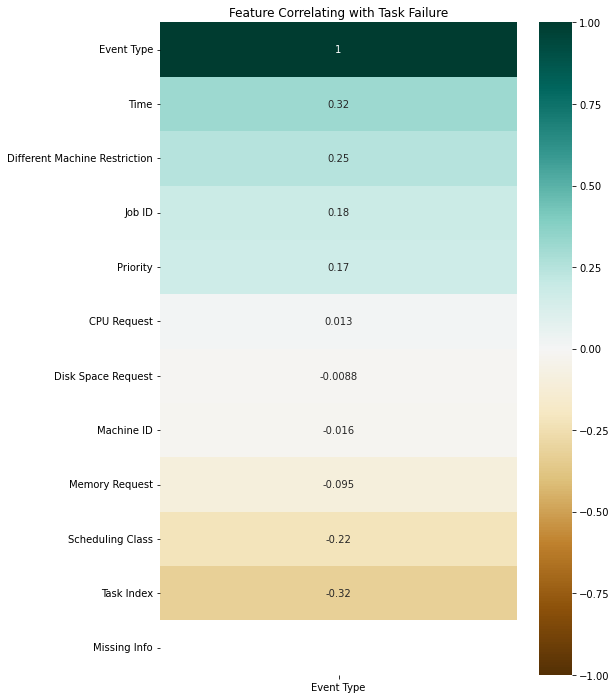

In [ ]:
plt.figure(figsize=(8,12))
heatmap = sns.heatmap(task_event.corr()[['Event Type']].sort_values(by='Event Type', ascending=False).compute(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Feature Correlating with Task Failure')

In [ ]:
task_event = task_event.drop(columns=['Missing Info','Job ID','Task Index','Machine ID','Time','User Name','Different Machine Restriction'])

In [ ]:
task_event.head()

,Event Type,Scheduling Class,Priority,CPU Request,Memory Request,Disk Space Request
277322,1.0,0.0,2.0,0.02499,0.07959,0.000386
277323,1.0,0.0,2.0,0.02499,0.07959,0.000386
277324,1.0,0.0,2.0,0.02499,0.07959,0.000386
277325,1.0,0.0,2.0,0.02499,0.07959,0.000386
277326,1.0,0.0,2.0,0.02499,0.07959,0.000386


In [ ]:
task_event.to_csv('Selected Task.csv', single_file=True)

## Modelling
---

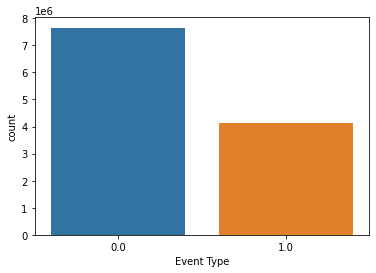

In [12]:
sns.countplot(data=task_event.compute(),x='Event Type')
plt.show()

In [13]:
x = task_event.drop(columns=['Event Type']).compute()
y = task_event['Event Type'].compute()

### SMOTE
---
In this section, we use SMOTE function to generate synthetic data to solve the class imbalance before we start the model training

In [15]:
sampling_method = SMOTE()
x,y = sampling_method.fit_resample(x,y)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3)

### Traditional Machine Learning Model

#### Logistic Regression

In [16]:
Logistic_Regression = LogisticRegression(max_iter=10000000)
Logistic_Regression.fit(X_train, Y_train.values.ravel())
joblib.dump(Logistic_Regression, 'Logistic Regression.model')

['Logistic Regression.model']

#### Decision Tree

In [17]:
Decision_Tree = DecisionTreeClassifier()
Decision_Tree.fit(X_train, Y_train)
joblib.dump(Decision_Tree, 'Decision Tree.model')

['Decision Tree.model']

#### Random Forest

In [18]:
Random_Forest = RandomForestClassifier()
Random_Forest.fit(X_train, Y_train.values.ravel())
joblib.dump(Random_Forest, 'Random Forest.model')

['Random Forest.model']

#### Gradient Boosting

In [19]:
Gradient_Boosting = GradientBoostingClassifier()
Gradient_Boosting.fit(X_train, Y_train.values.ravel())
joblib.dump(Gradient_Boosting, 'Gradient Boosting.model')

['Gradient Boosting.model']

#### Extreme Gradient Boosting

In [20]:
XG_Boost = XGBClassifier()
XG_Boost.fit(X_train, Y_train.values.ravel())
joblib.dump(XG_Boost, 'Extreme Gradient Boosting.model')

[23:39:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


['Extreme Gradient Boosting.model']

### Deep Learning Model

In [21]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 10, restore_best_weights = True)

#### Single Layer LSTM

In [26]:
LSTM1 = Sequential()

LSTM1.add(LSTM(units = 50, input_shape = (X_train.shape[1], 1)))
LSTM1.add(Dropout(0.2))

LSTM1.add(Dense(units = 1))

LSTM1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

LSTM1.fit(X_train, Y_train,validation_data=(X_test, Y_test), epochs=100, callbacks=[earlystopping])

LSTM1.save('LSTM1.keras')

Epoch 1/100
334802/334802 [==============================] - 2510s 7ms/step - loss: 0.4199 - accuracy: 0.8349 - val_loss: 0.3553 - val_accuracy: 0.8519
Epoch 2/100
334802/334802 [==============================] - 2504s 7ms/step - loss: 0.3541 - accuracy: 0.8624 - val_loss: 0.3248 - val_accuracy: 0.8794
Epoch 3/100
334802/334802 [==============================] - 2809s 8ms/step - loss: 0.3231 - accuracy: 0.8806 - val_loss: 0.3051 - val_accuracy: 0.8868
Epoch 4/100
334802/334802 [==============================] - 2761s 8ms/step - loss: 0.3145 - accuracy: 0.8842 - val_loss: 0.2964 - val_accuracy: 0.8886
Epoch 5/100
334802/334802 [==============================] - 2732s 8ms/step - loss: 0.3128 - accuracy: 0.8854 - val_loss: 0.3039 - val_accuracy: 0.8911
Epoch 6/100
334802/334802 [==============================] - 2738s 8ms/step - loss: 0.3069 - accuracy: 0.8883 - val_loss: 0.3034 - val_accuracy: 0.8929
Epoch 7/100
334802/334802 [==============================] - 2736s 8ms/step - loss: 0.30

#### Bi-Layer LSTM

In [27]:
LSTM2 = Sequential()

LSTM2.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
LSTM2.add(Dropout(0.2))

LSTM2.add(LSTM(units = 50))
LSTM2.add(Dropout(0.2))

LSTM2.add(Dense(units = 1))

LSTM2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

LSTM2.fit(X_train, Y_train,validation_data=(X_test, Y_test), epochs=100, callbacks=[earlystopping])

LSTM2.save('LSTM2.keras')

Epoch 1/100
334802/334802 [==============================] - 4379s 13ms/step - loss: 0.4122 - accuracy: 0.8382 - val_loss: 0.3901 - val_accuracy: 0.8489
Epoch 2/100
334802/334802 [==============================] - 4353s 13ms/step - loss: 0.3685 - accuracy: 0.8549 - val_loss: 0.3313 - val_accuracy: 0.8783
Epoch 3/100
334802/334802 [==============================] - 4353s 13ms/step - loss: 0.3348 - accuracy: 0.8735 - val_loss: 0.3532 - val_accuracy: 0.8726
Epoch 4/100
334802/334802 [==============================] - 4347s 13ms/step - loss: 0.3243 - accuracy: 0.8808 - val_loss: 0.3016 - val_accuracy: 0.8812
Epoch 5/100
334802/334802 [==============================] - 4332s 13ms/step - loss: 0.3037 - accuracy: 0.8874 - val_loss: 0.3053 - val_accuracy: 0.8928
Epoch 6/100
334802/334802 [==============================] - 4337s 13ms/step - loss: 0.2948 - accuracy: 0.8895 - val_loss: 0.2976 - val_accuracy: 0.8950
Epoch 7/100
334802/334802 [==============================] - 4334s 13ms/step - los

#### Tri-Layer LSTM

In [28]:
LSTM3 = Sequential()

LSTM3.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
LSTM3.add(Dropout(0.2))

LSTM3.add(LSTM(units = 50, return_sequences = True))
LSTM3.add(Dropout(0.2))

LSTM3.add(LSTM(units = 50))
LSTM3.add(Dropout(0.2))

LSTM3.add(Dense(units = 1))

LSTM3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

history3 = LSTM3.fit(X_train, Y_train,validation_data=(X_test, Y_test), epochs=100, callbacks=[earlystopping])

LSTM3.save('LSTM3.keras')

Epoch 1/100
334802/334802 [==============================] - 6000s 18ms/step - loss: 0.4187 - accuracy: 0.8369 - val_loss: 0.3229 - val_accuracy: 0.8820
Epoch 2/100
334802/334802 [==============================] - 6028s 18ms/step - loss: 0.3482 - accuracy: 0.8684 - val_loss: 0.3021 - val_accuracy: 0.8907
Epoch 3/100
334802/334802 [==============================] - 6053s 18ms/step - loss: 0.3214 - accuracy: 0.8819 - val_loss: 0.2994 - val_accuracy: 0.8916
Epoch 4/100
334802/334802 [==============================] - 6119s 18ms/step - loss: 0.3180 - accuracy: 0.8845 - val_loss: 0.2893 - val_accuracy: 0.8900
Epoch 5/100
334802/334802 [==============================] - 6088s 18ms/step - loss: 0.3145 - accuracy: 0.8846 - val_loss: 0.2978 - val_accuracy: 0.8925
Epoch 6/100
334802/334802 [==============================] - 6220s 19ms/step - loss: 0.3038 - accuracy: 0.8888 - val_loss: 0.2990 - val_accuracy: 0.8851 0
Epoch 7/100
334802/334802 [==============================] - 6430s 19ms/step - l